In [322]:
#import dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',None)

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import decomposition
from sklearn.cluster import KMeans

In [323]:
#load dataset
train = pd.read_csv('./datasets/train.csv')
test = pd.read_csv('./datasets/test.csv')

In [324]:
#Create copy of train and test
traincopy = train.copy()
testcopy = test.copy()

In [325]:
#Split the hours into day and night
nighthours = [ 1,  2,  3,  4,  5,  6,  7,  8,  9,10]
dayhours = [11, 12, 13, 14, 15, 16,17, 18, 19, 20, 21, 22, 23,0]

In [326]:
#split the data into day and night
train_day = train[train['Hour'].isin(dayhours)]
train_night = train[train['Hour'].isin(nighthours)]

test_day = test[test['Hour'].isin(dayhours)]
test_night = test[test['Hour'].isin(nighthours)]

In [327]:
def falg_func(x):
    #flag function
    if x==1:
        return 1
    elif x==2:
        return 2
    elif x==3:
        return 3
    elif x==4:
        return 4
    else:
        return 0
    
def season_map(x):
    if (x == 12 or x==  1 or  x ==2):
        return 1
    if (x == 3 or x== 4  or  x ==5):
        return 2
    if (x == 6 or x==  7 or  x ==8):
        return 3
    if (x == 9 or x==  10 or  x ==11):
        return 4

### Preprocessing

In [328]:
#calculate GHI 
ghi_estmates = train['Clearsky DNI']*np.cos(train['Solar Zenith Angle']*np.pi/180)+train['Clearsky DHI']

In [329]:
#concat train and test data
train_day['Phase'] = 'train'
test_day['Phase'] = 'test'
alldf = pd.concat([train_day,test_day],axis=0)

In [330]:
def preprocessing(train):
    #TIME features (year montd day and time)
    train['time'] = pd.to_datetime(train[['Year','Month','Day','Hour','Minute']])

    #diff between temp and due point  ~ 
    #he smaller the difference between the temp and the dew_point, the higher the RH
    train['dewpoint-temp'] = train['Temperature']-train['Dew Point']

    #RelativeHumidity and temp
    train['RHxTemp'] = train['Relative Humidity']*train['Temperature']

    #Relative Humidity Index(RHI)
    train['RHI'] = 0.8*train['Temperature']+train['Relative Humidity']/100*(train['Temperature']-14.4)+46
    
    #flag function
    train['Fill Flag'] = train['Fill Flag'].apply(falg_func)

    #pressure class
    train['Pressure_class'] =pd.cut(train['Pressure'],bins=[0,999,1008,1013,1040],labels=[0,1,2,3])

    #wind directions class 
    train['WindDirection_Class'] = pd.cut(train['Wind Direction'],bins=8,labels=[1,2,3,4,5,6,7,8])

    #sine transform of wind direction
    train['WindDirection_Sine'] = (np.sin(train['Wind Direction']*(np.pi/180)))

    #outliers - Cloudtype 10 replace with 0
    train['Cloud Type'][train['Cloud Type']==10] = 0
    return train

In [331]:
# #preprocessing for train and test data
# train = preprocessing(train)
# test = preprocessing(test)

In [332]:
#preprocessing for train and test data
alldf = preprocessing(alldf)

#split the data into train and test
train = alldf[alldf['Phase']=='train']
test = alldf[alldf['Phase']=='test']

In [333]:
def iqr_range(value):
    q1 = value.quantile(0.25)
    q3 = value.quantile(0.75)
    iqr = q3 - q1
    return q1-1.5*iqr,q3+1.5*iqr

<AxesSubplot:xlabel='time', ylabel='Clearsky DHI'>

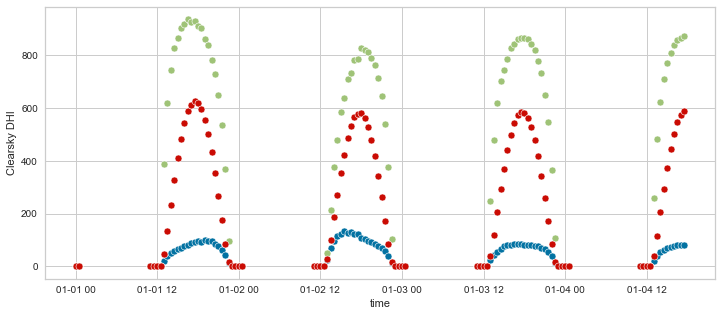

In [334]:
#visualize each target features
plt.figure(figsize=(12,5))
subdf = train[:100]
sns.scatterplot(data=subdf,x='time',y='Clearsky DHI')
sns.scatterplot(data=subdf,x='time',y='Clearsky DNI')
sns.scatterplot(data=subdf,x='time',y='Clearsky GHI')

* The day and night time periods
* There might be some correlation between target varibles (we found the equation for GHI)

* a region with a temperature of 18° and relative humidity of 40% is considered too dry whereas the region with 23° temperature and 70% relative humidity comes in the range of too moist regions. The regions between these two extremes are acceptable such as regions with 24° temperature and 50% humidity. In this way, their relationship affects the region.

* Relation between pressure and clouds

## Feature Engineering

In [335]:
def feature_engineering(train):
    #Seasons
    train['Season'] =  train['Month'].apply(lambda x:season_map(x))
    
    #Mean Humidity ZeningAngle WindDire by Hour and Minute
    train[['RelHumid_HourMinute','ZenithAng_HourMinute','WindDir_HourMinute']] =\
            train.groupby(['Hour','Minute'])['Relative Humidity', 'Solar Zenith Angle','Wind Direction'].transform('mean')

    #Mean Humidity ZeningAngle WindDire Temperature by Year and Month
    train[['RelHumid_YearMonth','WindDir_YearMonth','Temp_YearMonth']] =\
                train.groupby(['Year','Month'])['Relative Humidity','Wind Direction','Temperature'].transform('mean')

    #Mean Humidity ZeningAngle WindDire Temperature by Year and Month
    train[['RelHumid_SeasonYear','WindDir_SeasonYear','Temp_SeasonYear']] =\
                train.groupby(['Season','Year'])['Relative Humidity','Wind Direction','Temperature'].transform('mean')

    # Delta (diff)
    #change in Humidity
    train['delta_RelativeHumidity'] = train['Relative Humidity'].diff()
    #change in Temperature
    train['delta_Temperature'] = train['Temperature'].diff()
    #change in Dew Point
    train['delta_DewPoint'] = train['Dew Point'].diff()
    #change in Precipitable Water
    train['delta_PrecipWater'] = train['Precipitable Water'].diff()
    #change in Wind Speed
    train['delta_WindSpeed'] = train['Wind Speed'].diff()

    #Cloud Types and Pressure Class
    train[['CloudPressure_RelaHumidity', 'CloudPressure_PrecWater','CloudPressure_DewPoint','CloudPressure_Temp']] =\
    train.groupby(['Pressure_class','Cloud Type'])['Relative Humidity', 'Precipitable Water','Dew Point','Temperature'].transform('mean')
    
    return train

In [336]:
#feature engineering 
alldf = feature_engineering(alldf)
#split the data into train and test
train = alldf[alldf['Phase']=='train']
test = alldf[alldf['Phase']=='test']

#drop nan obs values in moving averages (drop entire row)
train = train.dropna(axis=0).reset_index(drop=True)
alldf = pd.concat([train,test],axis=0)

In [337]:
num_feats = ['Temperature','Pressure', 'Relative Humidity', 'Solar Zenith Angle',
'Precipitable Water', 'Wind Direction', 'Wind Speed', 'Fill Flag',
'ZenithAng_HourMinute', 'WindDir_HourMinute', 'RelHumid_YearMonth',
'WindDir_YearMonth', 'Temp_YearMonth', 'RelHumid_SeasonYear',
'WindDir_SeasonYear', 'Temp_SeasonYear', 'delta_RelativeHumidity',
'delta_Temperature', 'delta_DewPoint', 'delta_PrecipWater',
'delta_WindSpeed',
# 'MA_RelativeHumidity', 'MA_Temperature','MA_DewPoint', 
# 'MA_PrecipitableWater', 'MA_WindSpeed','MA_WindDirection',
'CloudPressure_RelaHumidity',
'CloudPressure_PrecWater', 'CloudPressure_DewPoint',
'CloudPressure_Temp']

In [338]:
#pca components as new features
pca = decomposition.IncrementalPCA(n_components=10)
emb = pca.fit_transform(alldf[num_feats].values)

for i in range(emb.shape[1]):
    alldf[f'pca_{i+1}'] = emb[:, i]

In [339]:
#try pca
avoidcols = ['Clearsky DNI','Clearsky DHI','Clearsky GHI','time','Phase']
trainX = train.drop(columns=avoidcols)
avoidcolumns_train = train[avoidcols]

testX = test.drop(columns=avoidcols)
avoidcolumns_test = test[avoidcols]

# scale trainX using StandardScaler
sc = StandardScaler()
train_pca = sc.fit_transform(trainX)
test_pca = sc.transform(testX)

#pca with 95% variance
pca = PCA(n_components = 0.99)
 
pca_Train = pca.fit_transform(train_pca)
pca_Test = pca.transform(test_pca)

#variance
explained_variance = pca.explained_variance_ratio_
pcadf = pd.DataFrame(pca.components_, columns=list(trainX.columns))

#crate dataframe of pca table
pca_Train = pd.DataFrame(pca_Train)
pca_Test = pd.DataFrame(pca_Test)

#concat pca table and avoidcolumns
pca_Train = pd.concat([pca_Train,avoidcolumns_train],axis=1)
pca_Test = pd.concat([pca_Test,avoidcolumns_train],axis=1)

In [340]:
# Fit the KMeans model to create cluster labels
kmeans = KMeans(n_clusters=2, n_init=50, random_state=0)
alldf['cluster']=  kmeans.fit_predict(alldf[num_feats].values)

In [341]:
#split the features into train and test
train = alldf[alldf['Phase']=='train']
test = alldf[alldf['Phase']=='test']

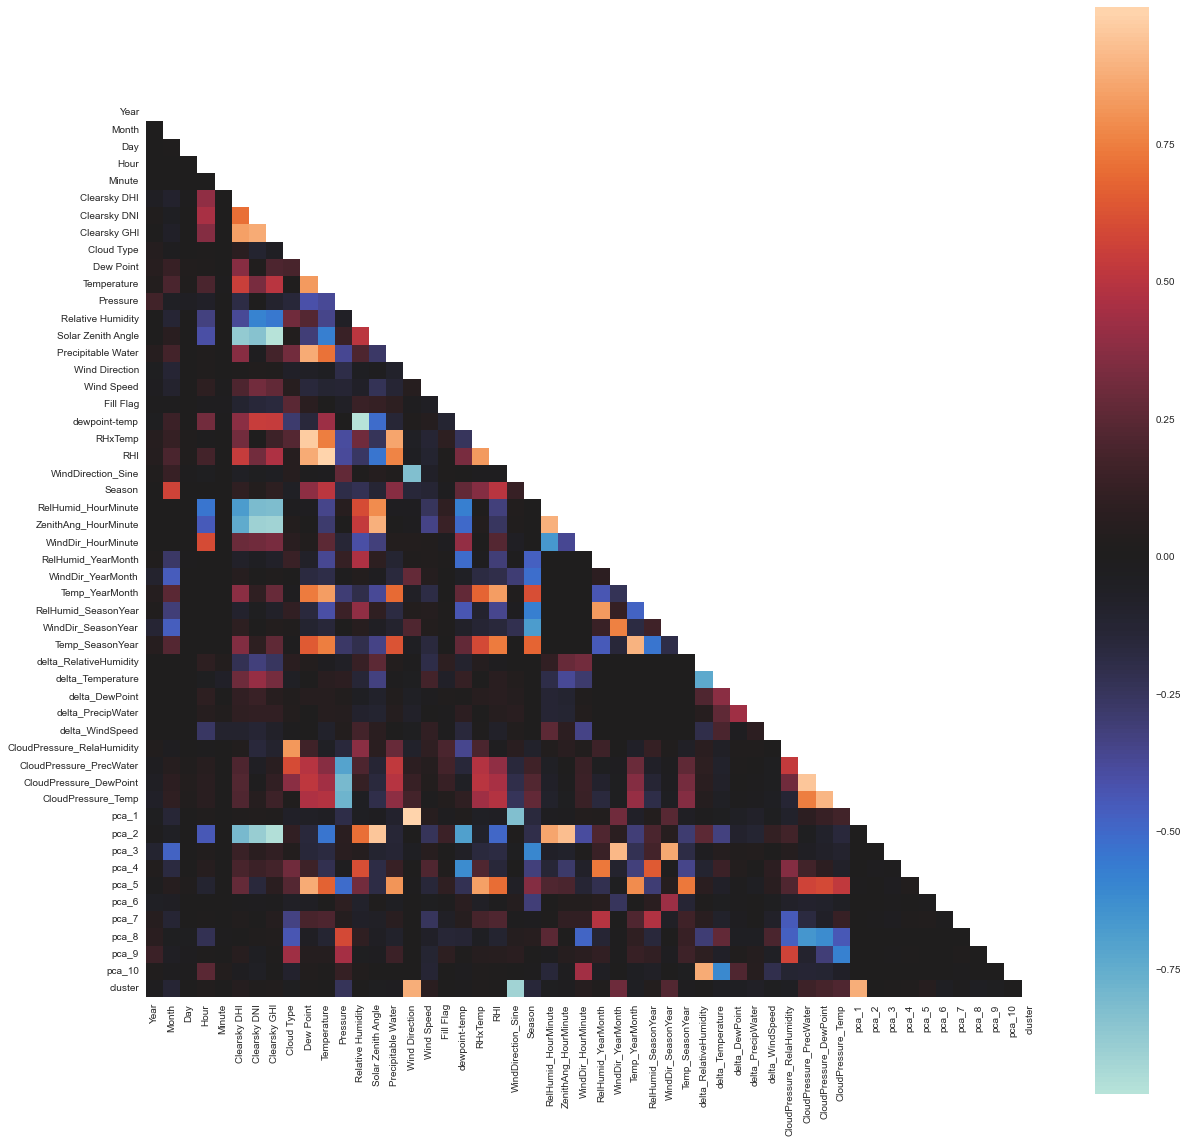

In [342]:
#Correlation
corr = train.corr()
matrix = np.triu(corr)
plt.figure(figsize=(20,20))
sns.heatmap(corr, annot = False,square=True,mask=matrix,center=0,linewidths=0)
plt.show()

In [270]:
# Create correlation matrix
targets = ['Clearsky DNI','Clearsky DHI','Clearsky GHI']
corr_matrix = train.drop(targets,axis=1).corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Modelling

## 1 - CatBoost

In [225]:
import catboost as cb
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
import optuna
from optuna.samplers import TPESampler

### Estimate DHI

In [228]:
# Split the train data into train and validation
traindf, validationdf = train_test_split(train, test_size=0.2,shuffle=False)

### Parameter Tuning for DHI

In [232]:
#Hyperparameter Tuning for DHI
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    param = {
        "loss_function": "RMSE",
#          "n_estimators" : 900,
#         "n_estimators" : trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_loguniform("learning_rate",0.01,0.05),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 4, 10),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 20),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1, 10),
            }
    # Conditional Hyper-Parameters
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    reg = CatBoostRegressor(**param, cat_features=categorical_features_indices,use_best_model=True)
    reg.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=100)
    y_pred = reg.predict(X_test)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    return score

In [233]:
avoid_cols = ['Year','Clearsky DNI','Clearsky DHI','Clearsky GHI','time','Phase']
target = 'Clearsky DHI'
feats = [col for col in traindf.columns if col not in avoid_cols]
X = traindf.drop(columns=avoid_cols)
y = traindf[target]

categorical_features_indices = np.where(X.dtypes != np.float)[0]
study_DHI = optuna.create_study(sampler=TPESampler(), direction="minimize")
study_DHI.optimize(objective, n_trials=10, timeout=900) # Run for 10 minutes
print("Number of completed trials: {}".format(len(study_DHI.trials)))
print("Best trial:")
trial = study_DHI.best_trial

print("\tBest Score: {}".format(trial.value))
print("\tBest Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-02-11 20:30:26,418] A new study created in memory with name: no-name-0e40fcdc-f6e6-432a-82a7-eefe51d69f22
Custom logger is already specified. Specify more than one logger at same time is not thread safe.[I 2022-02-11 20:32:23,161] Trial 0 finished with value: 18.780874581471167 and parameters: {'n_estimators': 521, 'learning_rate': 0.01665467952972361, 'depth': 7, 'l2_leaf_reg': 3.0119926972482816}. Best is trial 0 with value: 18.780874581471167.
[I 2022-02-11 20:36:48,185] Trial 1 finished with value: 12.972788290770515 and parameters: {'n_estimators': 945, 'learning_rate': 0.0367250359539884, 'depth': 9, 'l2_leaf_reg': 2.393135598932241}. Best is trial 1 with value: 12.972788290770515.
[I 2022-02-11 20:40:46,744] Trial 2 finished with value: 17.46652747166334 and parameters: {'n_estimators': 797, 'learning_rate': 0.01029034659685532, 'depth': 9, 'l2_leaf_reg': 3.1451365514721106}. Best is trial 1 with value: 12.972788290770515.
[I 2022-02-11 20:40:56,423] Trial 3 finished wit

Number of completed trials: 8
Best trial:
	Best Score: 12.972788290770515
	Best Params: 
    n_estimators: 945
    learning_rate: 0.0367250359539884
    depth: 9
    l2_leaf_reg: 2.393135598932241


In [234]:
#best parameters
trial_DHI = study_DHI.best_trial
best_params_DHI = trial_DHI.params

feats = [col for col in traindf.columns if col not in avoid_cols]
# Categorical features
cat_cols = ['Month','Hour','Minute','Fill Flag','Zenith Angle Class','Pressure_class','WindDirection_Class']
# Categorical features index 
cat_indx = [i for i,c in enumerate(feats) if c in cat_cols]

# Catboost pool
val_pool = cb.Pool(validationdf[feats].values, validationdf[target], cat_features=cat_indx)

# Model setup
cat_reg_DHI = cb.CatBoostRegressor(**best_params_DHI, early_stopping_rounds=100)
# Model fit
cat_reg_DHI.fit(X=traindf[feats], y=traindf[target], eval_set=val_pool, 
            cat_features=cat_indx, use_best_model=True, verbose=True, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 59.2064902	test: 54.6988947	best: 54.6988947 (0)	total: 201ms	remaining: 3m 10s
1:	learn: 57.4423873	test: 52.9531275	best: 52.9531275 (1)	total: 403ms	remaining: 3m 9s
2:	learn: 55.7832344	test: 51.3369322	best: 51.3369322 (2)	total: 600ms	remaining: 3m 8s
3:	learn: 54.1608439	test: 49.7655092	best: 49.7655092 (3)	total: 785ms	remaining: 3m 4s
4:	learn: 52.6123875	test: 48.2588053	best: 48.2588053 (4)	total: 1.02s	remaining: 3m 12s
5:	learn: 51.1132505	test: 46.7897838	best: 46.7897838 (5)	total: 1.23s	remaining: 3m 11s
6:	learn: 49.6654811	test: 45.3686018	best: 45.3686018 (6)	total: 1.41s	remaining: 3m 9s
7:	learn: 48.3484143	test: 44.1064889	best: 44.1064889 (7)	total: 1.61s	remaining: 3m 8s
8:	learn: 47.0441536	test: 42.8406756	best: 42.8406756 (8)	total: 1.82s	remaining: 3m 8s
9:	learn: 45.7781390	test: 41.6038273	best: 41.6038273 (9)	total: 2.02s	remaining: 3m 9s
10:	learn: 44.5907556	test: 40.4613765	best: 40.4613765 (10)	total: 2.21s	remaining: 3m 7s
11:	learn: 43.43

91:	learn: 19.7983389	test: 21.2726266	best: 21.2587039 (88)	total: 18.7s	remaining: 2m 53s
92:	learn: 19.7478671	test: 21.2768906	best: 21.2587039 (88)	total: 18.9s	remaining: 2m 52s
93:	learn: 19.7134850	test: 21.2738813	best: 21.2587039 (88)	total: 19.1s	remaining: 2m 52s
94:	learn: 19.6738048	test: 21.2766697	best: 21.2587039 (88)	total: 19.3s	remaining: 2m 52s
95:	learn: 19.6178566	test: 21.2841731	best: 21.2587039 (88)	total: 19.5s	remaining: 2m 52s
96:	learn: 19.5877996	test: 21.2838959	best: 21.2587039 (88)	total: 19.7s	remaining: 2m 51s
97:	learn: 19.5455062	test: 21.2874823	best: 21.2587039 (88)	total: 19.9s	remaining: 2m 51s
98:	learn: 19.5097447	test: 21.2963557	best: 21.2587039 (88)	total: 20.1s	remaining: 2m 51s
99:	learn: 19.4842989	test: 21.2909905	best: 21.2587039 (88)	total: 20.2s	remaining: 2m 51s
100:	learn: 19.4384526	test: 21.3037827	best: 21.2587039 (88)	total: 20.4s	remaining: 2m 50s
101:	learn: 19.3987594	test: 21.3102999	best: 21.2587039 (88)	total: 20.6s	rema

180:	learn: 17.2455781	test: 21.5327995	best: 21.2587039 (88)	total: 40.4s	remaining: 2m 50s
181:	learn: 17.2223584	test: 21.5373091	best: 21.2587039 (88)	total: 40.6s	remaining: 2m 50s
182:	learn: 17.2144523	test: 21.5372752	best: 21.2587039 (88)	total: 40.8s	remaining: 2m 49s
183:	learn: 17.1756593	test: 21.5381364	best: 21.2587039 (88)	total: 41s	remaining: 2m 49s
184:	learn: 17.1595308	test: 21.5357556	best: 21.2587039 (88)	total: 41.2s	remaining: 2m 49s
185:	learn: 17.1324424	test: 21.5249986	best: 21.2587039 (88)	total: 41.4s	remaining: 2m 48s
186:	learn: 17.1160015	test: 21.5214300	best: 21.2587039 (88)	total: 41.6s	remaining: 2m 48s
187:	learn: 17.0948447	test: 21.5224980	best: 21.2587039 (88)	total: 41.8s	remaining: 2m 48s
188:	learn: 17.0831640	test: 21.5334677	best: 21.2587039 (88)	total: 42s	remaining: 2m 48s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 21.25870386
bestIteration = 88

Shrink model to first 89 iterations.


In [117]:
#Predict for test data
target = 'Clearsky DHI'
test_pred = cat_reg_DHI.predict(test[feats])
test[target] = test_pred

### Estimate DNI

### Parameter Tuning for DNI

In [ ]:
avoid_cols = ['Year','Clearsky DNI','Clearsky DHI','Clearsky GHI','time']
target = 'Clearsky DNI'
X = train.drop(columns=avoid_cols)
y = train[target]

categorical_features_indices = np.where(X.dtypes != np.float)[0]
study_DNI = optuna.create_study(sampler=TPESampler(), direction="minimize")
study_DNI.optimize(objective, n_trials=10, timeout=900) # Run for 10 minutes
print("Number of completed trials: {}".format(len(study_DNI.trials)))
print("Best trial:")
trial_DNI = study_DNI.best_trial

print("\tBest Score: {}".format(trial_DNI.value))
print("\tBest Params: ")
for key, value in trial_DNI.params.items():
    print("    {}: {}".format(key, value))

In [171]:
#best parameters
trial_DNI = study_DNI.best_trial
best_params_DNI = trial_DNI.params

avoid_cols = ['Year','Clearsky DNI','Clearsky DHI','Clearsky GHI','time','Phase']
feats = [col for col in traindf.columns if col not in avoid_cols]
target = 'Clearsky DNI'

# Categorical features
cat_cols = ['Month','Hour','Minute','Fill Flag','Zenith Angle Class','Pressure_class','WindDirection_Class']
# Categorical features index 
cat_indx = [i for i,c in enumerate(feats) if c in cat_cols]

# Catboost pool
val_pool = cb.Pool(validationdf[feats].values, validationdf[target], cat_features=cat_indx)

#fit model using best params
cat_reg_DNI = cb.CatBoostRegressor(**best_params_DNI,early_stopping_rounds=100)
cat_reg_DNI.fit(X=traindf[feats], y=traindf[target], eval_set=val_pool, 
            cat_features=cat_indx, use_best_model=True, verbose=True, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 313.3753011	test: 312.4558146	best: 312.4558146 (0)	total: 39.5ms	remaining: 59.2s
1:	learn: 309.1753174	test: 308.2501888	best: 308.2501888 (1)	total: 47.8ms	remaining: 35.8s
2:	learn: 304.7389922	test: 303.8175980	best: 303.8175980 (2)	total: 71.6ms	remaining: 35.7s
3:	learn: 304.7389635	test: 303.8175617	best: 303.8175617 (3)	total: 77.2ms	remaining: 28.9s
4:	learn: 299.7567980	test: 298.8329298	best: 298.8329298 (4)	total: 129ms	remaining: 38.5s
5:	learn: 294.9599693	test: 294.0536160	best: 294.0536160 (5)	total: 158ms	remaining: 39.3s
6:	learn: 292.3157252	test: 291.3878608	best: 291.3878608 (6)	total: 197ms	remaining: 42s
7:	learn: 291.4123144	test: 290.4845477	best: 290.4845477 (7)	total: 206ms	remaining: 38.5s
8:	learn: 286.7008895	test: 285.8131877	best: 285.8131877 (8)	total: 264ms	remaining: 43.7s
9:	learn: 282.2764028	test: 281.4045863	best: 281.4045863 (9)	total: 311ms	remaining: 46.4s
10:	learn: 278.0034652	test: 277.1575512	best: 277.1575512 (10)	total: 345ms	r

91:	learn: 120.9366709	test: 120.9726683	best: 120.9726683 (91)	total: 2.87s	remaining: 43.9s
92:	learn: 119.5405766	test: 119.5861552	best: 119.5861552 (92)	total: 2.91s	remaining: 44s
93:	learn: 118.1559491	test: 118.2166605	best: 118.2166605 (93)	total: 2.95s	remaining: 44.2s
94:	learn: 116.9594897	test: 117.0271729	best: 117.0271729 (94)	total: 3s	remaining: 44.4s
95:	learn: 116.8836441	test: 116.9532484	best: 116.9532484 (95)	total: 3s	remaining: 44s
96:	learn: 115.7983678	test: 115.8851504	best: 115.8851504 (96)	total: 3.03s	remaining: 43.8s
97:	learn: 114.4889687	test: 114.5879489	best: 114.5879489 (97)	total: 3.07s	remaining: 43.9s
98:	learn: 113.7274241	test: 113.8369178	best: 113.8369178 (98)	total: 3.12s	remaining: 44.1s
99:	learn: 112.5302266	test: 112.6525354	best: 112.6525354 (99)	total: 3.17s	remaining: 44.4s
100:	learn: 112.5302157	test: 112.6524825	best: 112.6524825 (100)	total: 3.18s	remaining: 44.1s
101:	learn: 112.4891448	test: 112.6104637	best: 112.6104637 (101)	to

181:	learn: 69.1870638	test: 69.9869361	best: 69.9869361 (181)	total: 5.85s	remaining: 42.4s
182:	learn: 69.0393721	test: 69.8481142	best: 69.8481142 (182)	total: 5.86s	remaining: 42.2s
183:	learn: 69.0393678	test: 69.8480739	best: 69.8480739 (183)	total: 5.87s	remaining: 42s
184:	learn: 69.0312650	test: 69.8397161	best: 69.8397161 (184)	total: 5.87s	remaining: 41.8s
185:	learn: 68.8200063	test: 69.6319566	best: 69.6319566 (185)	total: 5.9s	remaining: 41.7s
186:	learn: 68.6755655	test: 69.4883655	best: 69.4883655 (186)	total: 5.92s	remaining: 41.6s
187:	learn: 68.4215946	test: 69.2397260	best: 69.2397260 (187)	total: 5.97s	remaining: 41.7s
188:	learn: 68.1347236	test: 68.9560821	best: 68.9560821 (188)	total: 6.02s	remaining: 41.8s
189:	learn: 68.1347199	test: 68.9560446	best: 68.9560446 (189)	total: 6.03s	remaining: 41.6s
190:	learn: 67.9330179	test: 68.7569558	best: 68.7569558 (190)	total: 6.05s	remaining: 41.5s
191:	learn: 67.8788412	test: 68.7033909	best: 68.7033909 (191)	total: 6.0

275:	learn: 58.9029629	test: 60.0043738	best: 60.0043738 (275)	total: 8.64s	remaining: 38.3s
276:	learn: 58.8172935	test: 59.9223999	best: 59.9223999 (276)	total: 8.68s	remaining: 38.4s
277:	learn: 58.7340343	test: 59.8393105	best: 59.8393105 (277)	total: 8.73s	remaining: 38.4s
278:	learn: 58.6862675	test: 59.7910731	best: 59.7910731 (278)	total: 8.75s	remaining: 38.3s
279:	learn: 58.5391690	test: 59.6466799	best: 59.6466799 (279)	total: 8.79s	remaining: 38.4s
280:	learn: 58.4849283	test: 59.5980840	best: 59.5980840 (280)	total: 8.85s	remaining: 38.4s
281:	learn: 58.4024397	test: 59.5163833	best: 59.5163833 (281)	total: 8.87s	remaining: 38.4s
282:	learn: 58.2997571	test: 59.4143378	best: 59.4143378 (282)	total: 8.91s	remaining: 38.4s
283:	learn: 58.2473319	test: 59.3650647	best: 59.3650647 (283)	total: 8.95s	remaining: 38.4s
284:	learn: 58.2219487	test: 59.3403205	best: 59.3403205 (284)	total: 8.97s	remaining: 38.3s
285:	learn: 58.1802746	test: 59.2996564	best: 59.2996564 (285)	total: 

371:	learn: 54.3856583	test: 55.7045430	best: 55.7045430 (371)	total: 11.8s	remaining: 35.8s
372:	learn: 54.3369030	test: 55.6578162	best: 55.6578162 (372)	total: 11.8s	remaining: 35.8s
373:	learn: 54.3123619	test: 55.6365125	best: 55.6365125 (373)	total: 11.8s	remaining: 35.7s
374:	learn: 54.2508524	test: 55.5778797	best: 55.5778797 (374)	total: 11.9s	remaining: 35.7s
375:	learn: 54.2354420	test: 55.5635117	best: 55.5635117 (375)	total: 11.9s	remaining: 35.6s
376:	learn: 54.1902645	test: 55.5251066	best: 55.5251066 (376)	total: 11.9s	remaining: 35.6s
377:	learn: 54.1513740	test: 55.4857433	best: 55.4857433 (377)	total: 12s	remaining: 35.6s
378:	learn: 54.1109157	test: 55.4495752	best: 55.4495752 (378)	total: 12s	remaining: 35.6s
379:	learn: 54.0788247	test: 55.4173210	best: 55.4173210 (379)	total: 12.1s	remaining: 35.7s
380:	learn: 54.0288510	test: 55.3671142	best: 55.3671142 (380)	total: 12.1s	remaining: 35.7s
381:	learn: 54.0032045	test: 55.3455342	best: 55.3455342 (381)	total: 12.2

461:	learn: 52.0357589	test: 53.5358832	best: 53.5358832 (461)	total: 14.5s	remaining: 32.7s
462:	learn: 52.0087839	test: 53.5153570	best: 53.5153570 (462)	total: 14.6s	remaining: 32.7s
463:	learn: 51.9885002	test: 53.4963891	best: 53.4963891 (463)	total: 14.6s	remaining: 32.7s
464:	learn: 51.9673155	test: 53.4774320	best: 53.4774320 (464)	total: 14.6s	remaining: 32.6s
465:	learn: 51.9449394	test: 53.4543537	best: 53.4543537 (465)	total: 14.7s	remaining: 32.6s
466:	learn: 51.9412784	test: 53.4506625	best: 53.4506625 (466)	total: 14.7s	remaining: 32.5s
467:	learn: 51.9404772	test: 53.4504947	best: 53.4504947 (467)	total: 14.7s	remaining: 32.5s
468:	learn: 51.9122955	test: 53.4196486	best: 53.4196486 (468)	total: 14.8s	remaining: 32.5s
469:	learn: 51.8767730	test: 53.3846684	best: 53.3846684 (469)	total: 14.8s	remaining: 32.5s
470:	learn: 51.8407027	test: 53.3535815	best: 53.3535815 (470)	total: 14.9s	remaining: 32.5s
471:	learn: 51.8084694	test: 53.3241301	best: 53.3241301 (471)	total: 

552:	learn: 50.4830465	test: 52.1210115	best: 52.1210115 (552)	total: 16.9s	remaining: 29s
553:	learn: 50.4827907	test: 52.1207366	best: 52.1207366 (553)	total: 16.9s	remaining: 29s
554:	learn: 50.4584539	test: 52.0986891	best: 52.0986891 (554)	total: 17s	remaining: 28.9s
555:	learn: 50.4410146	test: 52.0842570	best: 52.0842570 (555)	total: 17s	remaining: 28.9s
556:	learn: 50.4270655	test: 52.0724395	best: 52.0724395 (556)	total: 17s	remaining: 28.9s
557:	learn: 50.4077628	test: 52.0583325	best: 52.0583325 (557)	total: 17.1s	remaining: 28.8s
558:	learn: 50.3846565	test: 52.0382911	best: 52.0382911 (558)	total: 17.1s	remaining: 28.8s
559:	learn: 50.3396592	test: 51.9978134	best: 51.9978134 (559)	total: 17.2s	remaining: 28.8s
560:	learn: 50.3204209	test: 51.9826326	best: 51.9826326 (560)	total: 17.2s	remaining: 28.8s
561:	learn: 50.3055167	test: 51.9687282	best: 51.9687282 (561)	total: 17.3s	remaining: 28.8s
562:	learn: 50.2888394	test: 51.9524063	best: 51.9524063 (562)	total: 17.3s	rema

644:	learn: 48.8664621	test: 50.6803792	best: 50.6803792 (644)	total: 19.8s	remaining: 26.2s
645:	learn: 48.8651675	test: 50.6793877	best: 50.6793877 (645)	total: 19.8s	remaining: 26.2s
646:	learn: 48.8430124	test: 50.6627775	best: 50.6627775 (646)	total: 19.8s	remaining: 26.2s
647:	learn: 48.8311434	test: 50.6489555	best: 50.6489555 (647)	total: 19.8s	remaining: 26.1s
648:	learn: 48.8168374	test: 50.6372130	best: 50.6372130 (648)	total: 19.9s	remaining: 26.1s
649:	learn: 48.8096060	test: 50.6291784	best: 50.6291784 (649)	total: 19.9s	remaining: 26.1s
650:	learn: 48.7788311	test: 50.6002959	best: 50.6002959 (650)	total: 19.9s	remaining: 26s
651:	learn: 48.7693386	test: 50.5919913	best: 50.5919913 (651)	total: 20s	remaining: 26s
652:	learn: 48.7655219	test: 50.5893635	best: 50.5893635 (652)	total: 20s	remaining: 25.9s
653:	learn: 48.7456298	test: 50.5750781	best: 50.5750781 (653)	total: 20s	remaining: 25.9s
654:	learn: 48.7446098	test: 50.5744076	best: 50.5744076 (654)	total: 20s	remain

739:	learn: 47.5287356	test: 49.4971890	best: 49.4971890 (739)	total: 22.4s	remaining: 23s
740:	learn: 47.5250856	test: 49.4952424	best: 49.4952424 (740)	total: 22.4s	remaining: 23s
741:	learn: 47.5250856	test: 49.4952404	best: 49.4952404 (741)	total: 22.4s	remaining: 23s
742:	learn: 47.5171092	test: 49.4886718	best: 49.4886718 (742)	total: 22.5s	remaining: 22.9s
743:	learn: 47.5053819	test: 49.4779748	best: 49.4779748 (743)	total: 22.5s	remaining: 22.9s
744:	learn: 47.4862752	test: 49.4612529	best: 49.4612529 (744)	total: 22.5s	remaining: 22.9s
745:	learn: 47.4862752	test: 49.4612508	best: 49.4612508 (745)	total: 22.5s	remaining: 22.8s
746:	learn: 47.4724549	test: 49.4525281	best: 49.4525281 (746)	total: 22.6s	remaining: 22.8s
747:	learn: 47.4530796	test: 49.4324219	best: 49.4324219 (747)	total: 22.6s	remaining: 22.8s
748:	learn: 47.4342057	test: 49.4181477	best: 49.4181477 (748)	total: 22.7s	remaining: 22.7s
749:	learn: 47.4182516	test: 49.4083556	best: 49.4083556 (749)	total: 22.7s	

833:	learn: 46.4737922	test: 48.6225028	best: 48.6225028 (833)	total: 25.2s	remaining: 20.2s
834:	learn: 46.4571453	test: 48.6097607	best: 48.6097607 (834)	total: 25.2s	remaining: 20.1s
835:	learn: 46.4522481	test: 48.6039112	best: 48.6039112 (835)	total: 25.3s	remaining: 20.1s
836:	learn: 46.4289963	test: 48.5831414	best: 48.5831414 (836)	total: 25.3s	remaining: 20.1s
837:	learn: 46.4064503	test: 48.5656631	best: 48.5656631 (837)	total: 25.3s	remaining: 20s
838:	learn: 46.3890920	test: 48.5508279	best: 48.5508279 (838)	total: 25.4s	remaining: 20s
839:	learn: 46.3631057	test: 48.5284707	best: 48.5284707 (839)	total: 25.4s	remaining: 20s
840:	learn: 46.3581074	test: 48.5252411	best: 48.5252411 (840)	total: 25.4s	remaining: 20s
841:	learn: 46.3382603	test: 48.5095326	best: 48.5095326 (841)	total: 25.5s	remaining: 20s
842:	learn: 46.3099942	test: 48.4844628	best: 48.4844628 (842)	total: 25.6s	remaining: 20s
843:	learn: 46.3028965	test: 48.4782694	best: 48.4782694 (843)	total: 25.6s	remain

927:	learn: 45.2894148	test: 47.6456488	best: 47.6456488 (927)	total: 28.4s	remaining: 17.5s
928:	learn: 45.2857088	test: 47.6425010	best: 47.6425010 (928)	total: 28.4s	remaining: 17.5s
929:	learn: 45.2715984	test: 47.6301584	best: 47.6301584 (929)	total: 28.5s	remaining: 17.5s
930:	learn: 45.2673758	test: 47.6257469	best: 47.6257469 (930)	total: 28.5s	remaining: 17.4s
931:	learn: 45.2461272	test: 47.6073608	best: 47.6073608 (931)	total: 28.5s	remaining: 17.4s
932:	learn: 45.2363726	test: 47.6012635	best: 47.6012635 (932)	total: 28.5s	remaining: 17.4s
933:	learn: 45.2231333	test: 47.5901228	best: 47.5901228 (933)	total: 28.6s	remaining: 17.4s
934:	learn: 45.2049313	test: 47.5765770	best: 47.5765770 (934)	total: 28.7s	remaining: 17.4s
935:	learn: 45.1905588	test: 47.5679855	best: 47.5679855 (935)	total: 28.8s	remaining: 17.4s
936:	learn: 45.1769623	test: 47.5559190	best: 47.5559190 (936)	total: 28.8s	remaining: 17.4s
937:	learn: 45.1506568	test: 47.5313244	best: 47.5313244 (937)	total: 

1016:	learn: 44.3616386	test: 46.8518810	best: 46.8518810 (1016)	total: 31.5s	remaining: 15s
1017:	learn: 44.3481194	test: 46.8439566	best: 46.8439566 (1017)	total: 31.5s	remaining: 14.9s
1018:	learn: 44.3480383	test: 46.8437417	best: 46.8437417 (1018)	total: 31.5s	remaining: 14.9s
1019:	learn: 44.3478590	test: 46.8434461	best: 46.8434461 (1019)	total: 31.5s	remaining: 14.9s
1020:	learn: 44.3317290	test: 46.8302065	best: 46.8302065 (1020)	total: 31.5s	remaining: 14.8s
1021:	learn: 44.3196073	test: 46.8219571	best: 46.8219571 (1021)	total: 31.6s	remaining: 14.8s
1022:	learn: 44.3005173	test: 46.8094325	best: 46.8094325 (1022)	total: 31.6s	remaining: 14.8s
1023:	learn: 44.2724681	test: 46.7853867	best: 46.7853867 (1023)	total: 31.7s	remaining: 14.7s
1024:	learn: 44.2605656	test: 46.7759106	best: 46.7759106 (1024)	total: 31.7s	remaining: 14.7s
1025:	learn: 44.2499423	test: 46.7664251	best: 46.7664251 (1025)	total: 31.7s	remaining: 14.7s
1026:	learn: 44.2407546	test: 46.7597595	best: 46.75

1105:	learn: 43.5034278	test: 46.1508638	best: 46.1508638 (1105)	total: 35.4s	remaining: 12.7s
1106:	learn: 43.4907505	test: 46.1413069	best: 46.1413069 (1106)	total: 35.5s	remaining: 12.6s
1107:	learn: 43.4905336	test: 46.1410401	best: 46.1410401 (1107)	total: 35.5s	remaining: 12.6s
1108:	learn: 43.4810676	test: 46.1333259	best: 46.1333259 (1108)	total: 35.5s	remaining: 12.6s
1109:	learn: 43.4756307	test: 46.1297717	best: 46.1297717 (1109)	total: 35.5s	remaining: 12.5s
1110:	learn: 43.4533441	test: 46.1104207	best: 46.1104207 (1110)	total: 35.6s	remaining: 12.5s
1111:	learn: 43.4533441	test: 46.1104189	best: 46.1104189 (1111)	total: 35.6s	remaining: 12.5s
1112:	learn: 43.4399087	test: 46.0996179	best: 46.0996179 (1112)	total: 35.6s	remaining: 12.4s
1113:	learn: 43.4255755	test: 46.0879698	best: 46.0879698 (1113)	total: 35.7s	remaining: 12.4s
1114:	learn: 43.4124256	test: 46.0799694	best: 46.0799694 (1114)	total: 35.7s	remaining: 12.4s
1115:	learn: 43.4011187	test: 46.0714956	best: 46.

1196:	learn: 42.8075342	test: 45.6035950	best: 45.6035950 (1196)	total: 38.8s	remaining: 9.85s
1197:	learn: 42.8074393	test: 45.6033711	best: 45.6033711 (1197)	total: 38.8s	remaining: 9.81s
1198:	learn: 42.8051835	test: 45.6017071	best: 45.6017071 (1198)	total: 38.8s	remaining: 9.78s
1199:	learn: 42.8003450	test: 45.5980273	best: 45.5980273 (1199)	total: 38.9s	remaining: 9.75s
1200:	learn: 42.7978938	test: 45.5958646	best: 45.5958646 (1200)	total: 38.9s	remaining: 9.72s
1201:	learn: 42.7865813	test: 45.5851751	best: 45.5851751 (1201)	total: 39s	remaining: 9.7s
1202:	learn: 42.7828165	test: 45.5831041	best: 45.5831041 (1202)	total: 39s	remaining: 9.67s
1203:	learn: 42.7825707	test: 45.5828867	best: 45.5828867 (1203)	total: 39.1s	remaining: 9.63s
1204:	learn: 42.7798792	test: 45.5803401	best: 45.5803401 (1204)	total: 39.1s	remaining: 9.6s
1205:	learn: 42.7619301	test: 45.5613923	best: 45.5613923 (1205)	total: 39.1s	remaining: 9.57s
1206:	learn: 42.7448834	test: 45.5506529	best: 45.550652

1285:	learn: 42.1296520	test: 45.0696801	best: 45.0696801 (1285)	total: 42.6s	remaining: 7.13s
1286:	learn: 42.1210617	test: 45.0618739	best: 45.0618739 (1286)	total: 42.7s	remaining: 7.09s
1287:	learn: 42.1199709	test: 45.0608300	best: 45.0608300 (1287)	total: 42.7s	remaining: 7.06s
1288:	learn: 42.1116847	test: 45.0546534	best: 45.0546534 (1288)	total: 42.7s	remaining: 7.03s
1289:	learn: 42.1116847	test: 45.0546519	best: 45.0546519 (1289)	total: 42.7s	remaining: 6.99s
1290:	learn: 42.1049068	test: 45.0498934	best: 45.0498934 (1290)	total: 42.8s	remaining: 6.96s
1291:	learn: 42.1038323	test: 45.0488976	best: 45.0488976 (1291)	total: 42.8s	remaining: 6.92s
1292:	learn: 42.0963966	test: 45.0435128	best: 45.0435128 (1292)	total: 42.8s	remaining: 6.88s
1293:	learn: 42.0957761	test: 45.0426274	best: 45.0426274 (1293)	total: 42.8s	remaining: 6.85s
1294:	learn: 42.0957761	test: 45.0426262	best: 45.0426262 (1294)	total: 42.8s	remaining: 6.81s
1295:	learn: 42.0790698	test: 45.0272209	best: 45.

1373:	learn: 41.4632201	test: 44.5469372	best: 44.5469372 (1373)	total: 46.7s	remaining: 4.32s
1374:	learn: 41.4565678	test: 44.5402170	best: 44.5402170 (1374)	total: 46.7s	remaining: 4.28s
1375:	learn: 41.4547988	test: 44.5388901	best: 44.5388901 (1375)	total: 46.8s	remaining: 4.25s
1376:	learn: 41.4461843	test: 44.5297354	best: 44.5297354 (1376)	total: 46.8s	remaining: 4.21s
1377:	learn: 41.4460312	test: 44.5297042	best: 44.5297042 (1377)	total: 46.8s	remaining: 4.18s
1378:	learn: 41.4460312	test: 44.5297032	best: 44.5297032 (1378)	total: 46.8s	remaining: 4.14s
1379:	learn: 41.4335975	test: 44.5193169	best: 44.5193169 (1379)	total: 46.9s	remaining: 4.11s
1380:	learn: 41.4145330	test: 44.5023934	best: 44.5023934 (1380)	total: 46.9s	remaining: 4.08s
1381:	learn: 41.4029273	test: 44.4912788	best: 44.4912788 (1381)	total: 47s	remaining: 4.04s
1382:	learn: 41.3896762	test: 44.4829201	best: 44.4829201 (1382)	total: 47s	remaining: 4.01s
1383:	learn: 41.3821263	test: 44.4795333	best: 44.4795

1461:	learn: 40.8277593	test: 44.0480869	best: 44.0480869 (1461)	total: 49.8s	remaining: 1.33s
1462:	learn: 40.8184088	test: 44.0396039	best: 44.0396039 (1462)	total: 49.9s	remaining: 1.29s
1463:	learn: 40.8045223	test: 44.0278654	best: 44.0278654 (1463)	total: 49.9s	remaining: 1.26s
1464:	learn: 40.7964098	test: 44.0251676	best: 44.0251676 (1464)	total: 49.9s	remaining: 1.23s
1465:	learn: 40.7923513	test: 44.0209656	best: 44.0209656 (1465)	total: 50s	remaining: 1.19s
1466:	learn: 40.7920588	test: 44.0205116	best: 44.0205116 (1466)	total: 50s	remaining: 1.16s
1467:	learn: 40.7915574	test: 44.0201843	best: 44.0201843 (1467)	total: 50s	remaining: 1.12s
1468:	learn: 40.7864098	test: 44.0173729	best: 44.0173729 (1468)	total: 50s	remaining: 1.09s
1469:	learn: 40.7704171	test: 44.0048056	best: 44.0048056 (1469)	total: 50.1s	remaining: 1.06s
1470:	learn: 40.7593080	test: 43.9949665	best: 43.9949665 (1470)	total: 50.1s	remaining: 1.02s
1471:	learn: 40.7457508	test: 43.9861521	best: 43.9861521 

In [122]:
#Predict for test data
target = 'Clearsky DNI'
test_pred = cat_reg_DNI.predict(test[feats])
test[target] = test_pred

### Estimate GHI

In [146]:
#combine test day and test night tables
testcopy.loc[test_day.index,['Clearsky DHI','Clearsky DNI']] = test[['Clearsky DHI','Clearsky DNI']]
testcopy.loc[test_night.index,['Clearsky DHI','Clearsky DNI']] = 0

In [153]:
predictiondf = testcopy.copy()

predictiondf['Clearsky DHI'] = predictiondf['Clearsky DHI'].apply(lambda x: 0 if x<=0 else x)
predictiondf['Clearsky DNI'] = predictiondf['Clearsky DNI'].apply(lambda x: 0 if x<=0 else x)

predictiondf['Clearsky DNI'][predictiondf['Clearsky DHI']==0] = 0
predictiondf['Clearsky DHI'][predictiondf['Clearsky DNI']==0] = 0

predictiondf['Clearsky GHI'] = predictiondf['Clearsky DNI']*np.cos(predictiondf['Solar Zenith Angle']*np.pi/180)+predictiondf['Clearsky DHI']

In [157]:
#save output
predictiondf[['Clearsky DHI','Clearsky DNI','Clearsky GHI']].to_csv('daynight001.csv',index=False)

## 2 - LightGBM

In [377]:
import lightgbm as lgb

In [378]:
# #concat train and test data
# train['Phase'] = 'train'
# test['Phase'] = 'test'
# alldf = pd.concat([train,test],axis=0)

#split numerical and categorical data
drop_feats = ['Year','time']
cat_feats = ['Month','Hour','Minute','Cloud Type','Fill Flag','Pressure_class','WindDirection_Class']

num_feats = [feat for feat in alldf.columns if (feat not in cat_feats and feat not in  drop_feats)]
num_feats.remove('Phase')

#get dummies for categorical features and drop drop_feats
finaldf =  pd.get_dummies(alldf,columns=cat_feats)
finaldf = finaldf.drop(columns=drop_feats)

#split the data into train and test
traindata = finaldf[finaldf['Phase']=='train']
testdata = finaldf[finaldf['Phase']=='test']
traindata.drop(columns='Phase',inplace=True)
testdata.drop(columns='Phase',inplace=True)

### Estimate DHI

In [392]:
#Parameter tuning
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=False)
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalidation = lgb.Dataset(X_test,label=y_test)
#     watchlist = [dvalidation]
    param = {
        'objective': 'regression',
        'metric': 'RMSE',
        "n_estimators": trial.suggest_int('n_estimators',300,1200),
        'learning_rate': trial.suggest_loguniform('learning_rate',0.01, 0.1),
#         'lambda_l1': trial.suggest_loguniform('lambda_l1',4, 10.0),
#         'lambda_l2': trial.suggest_loguniform('lambda_l2', 4, 10.0),
#         'num_leaves': trial.suggest_int('num_leaves', 30, 150),
#         'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
#         'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
#         'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    lgb_model = lgb.train(param,
                    train_set=dtrain,
                    valid_sets=[dtrain,dvalidation],
                    early_stopping_rounds=50)
    
    y_pred = lgb_model.predict(X_test)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    return score

In [393]:
target = 'Clearsky DHI'
targets = ['Clearsky DHI','Clearsky DNI','Clearsky GHI']
df_DHI = traindata.drop(columns = ['Clearsky DNI','Clearsky GHI'])
X = df_DHI.drop(columns=target,axis=1)
y = df_DHI[target]

study_DHI = optuna.create_study(sampler=TPESampler(), direction="minimize")
study_DHI.optimize(objective, n_trials=10, timeout=600) # Run for 10 minutes
print("Number of completed trials: {}".format(len(study_DHI.trials)))
print("Best trial:")
trial_DHI = study_DHI.best_trial

print("\tBest Score: {}".format(trial_DHI.value))
print("\tBest Params: ")
for key, value in trial_DHI.params.items():
    print("    {}: {}".format(key, value))

#best parameters
best_params_DHI = trial_DHI.params

[I 2022-02-12 10:51:25,308] A new study created in memory with name: no-name-b5d07b24-3e92-4086-9505-c5b77c8342f7


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5991
[LightGBM] [Info] Number of data points in the train set: 81804, number of used features: 96
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 91.827343
[1]	training's rmse: 59.5979	valid_1's rmse: 55.095
Training until validation scores don't improve for 50 rounds
[2]	training's rmse: 58.203	valid_1's rmse: 53.747
[3]	training's rmse: 56.8524	valid_1's rmse: 52.4463
[4]	training's rmse: 55.5441	valid_1's rmse: 51.1816
[5]	training's rmse: 54.2764	valid_1's rmse: 49.9562
[6]	training's rmse: 53.0477	valid_1's rmse: 48.7805
[7]	training's rmse: 51.8571	valid_1's rmse: 47.6342
[

[I 2022-02-12 10:51:28,547] Trial 0 finished with value: 21.217434382980496 and parameters: {'n_estimators': 440, 'learning_rate': 0.027547831097834593}. Best is trial 0 with value: 21.217434382980496.


[156]	training's rmse: 17.6052	valid_1's rmse: 21.4463
[157]	training's rmse: 17.5844	valid_1's rmse: 21.4474
[158]	training's rmse: 17.5542	valid_1's rmse: 21.4561
[159]	training's rmse: 17.5352	valid_1's rmse: 21.4539
[160]	training's rmse: 17.5132	valid_1's rmse: 21.4569
[161]	training's rmse: 17.493	valid_1's rmse: 21.4693
[162]	training's rmse: 17.4631	valid_1's rmse: 21.4704
Early stopping, best iteration is:
[112]	training's rmse: 18.9735	valid_1's rmse: 21.2174
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5991
[LightGBM] [Info] Number of data points in the train set: 81804, number of used features: 96
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 91.827343
[1]	training's rmse:

[149]	training's rmse: 19.9244	valid_1's rmse: 21.2812
[150]	training's rmse: 19.8873	valid_1's rmse: 21.2721
[151]	training's rmse: 19.8547	valid_1's rmse: 21.264
[152]	training's rmse: 19.8215	valid_1's rmse: 21.256
[153]	training's rmse: 19.7911	valid_1's rmse: 21.2505
[154]	training's rmse: 19.7527	valid_1's rmse: 21.2518
[155]	training's rmse: 19.7194	valid_1's rmse: 21.2487
[156]	training's rmse: 19.6868	valid_1's rmse: 21.2463
[157]	training's rmse: 19.6557	valid_1's rmse: 21.2426
[158]	training's rmse: 19.6272	valid_1's rmse: 21.242
[159]	training's rmse: 19.5909	valid_1's rmse: 21.2453
[160]	training's rmse: 19.5634	valid_1's rmse: 21.2425
[161]	training's rmse: 19.5324	valid_1's rmse: 21.2401
[162]	training's rmse: 19.5066	valid_1's rmse: 21.2386
[163]	training's rmse: 19.4771	valid_1's rmse: 21.2367
[164]	training's rmse: 19.4407	valid_1's rmse: 21.2421
[165]	training's rmse: 19.4146	valid_1's rmse: 21.2376
[166]	training's rmse: 19.3874	valid_1's rmse: 21.2412
[167]	trainin

[I 2022-02-12 10:51:32,742] Trial 1 finished with value: 21.233328054889128 and parameters: {'n_estimators': 677, 'learning_rate': 0.017135157101451814}. Best is trial 0 with value: 21.217434382980496.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5991
[LightGBM] [Info] Number of data points in the train set: 81804, number of used features: 96
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 91.827343
[1]	training's rmse: 58.5583	valid_1's rmse: 54.0869
Training until validation scores don't improve for 50 rounds
[2]	training's rmse: 56.2131	valid_1's rmse: 51.8192
[3]	training's rmse: 53.9966	valid_1's rmse: 49.694
[4]	training's rmse: 51.8944	valid_1's rmse: 47.6722
[5]	training's rmse: 49.914	valid_1's rmse: 45.7715
[6]	training's rmse: 48.036	valid_1's rmse: 43.985
[7]	training's rmse: 46.2651	valid_1's rmse: 42.298
[8]	training's rmse: 44.591	valid_1's rmse: 40.7178
[9]	training's 

[I 2022-02-12 10:51:35,125] Trial 2 finished with value: 21.268832737293103 and parameters: {'n_estimators': 818, 'learning_rate': 0.047502364352327894}. Best is trial 0 with value: 21.217434382980496.


[103]	training's rmse: 17.1925	valid_1's rmse: 21.6122
[104]	training's rmse: 17.1524	valid_1's rmse: 21.6211
[105]	training's rmse: 17.1203	valid_1's rmse: 21.6213
Early stopping, best iteration is:
[55]	training's rmse: 19.7632	valid_1's rmse: 21.2688
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5991
[LightGBM] [Info] Number of data points in the train set: 81804, number of used features: 96
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 91.827343
[1]	training's rmse: 60.4277	valid_1's rmse: 55.9004
Training until validation scores don't improve for 50 rounds
[2]	training's rmse: 59.8254	valid_1's rmse: 55.316
[3]	training's rmse: 59.2312	valid_1's rmse: 54.7411
[4]	training's rmse: 

[141]	training's rmse: 23.4414	valid_1's rmse: 22.7701
[142]	training's rmse: 23.3643	valid_1's rmse: 22.7241
[143]	training's rmse: 23.2925	valid_1's rmse: 22.6827
[144]	training's rmse: 23.2227	valid_1's rmse: 22.6415
[145]	training's rmse: 23.1496	valid_1's rmse: 22.5999
[146]	training's rmse: 23.0797	valid_1's rmse: 22.5597
[147]	training's rmse: 23.0082	valid_1's rmse: 22.5204
[148]	training's rmse: 22.9412	valid_1's rmse: 22.4804
[149]	training's rmse: 22.8747	valid_1's rmse: 22.4393
[150]	training's rmse: 22.8073	valid_1's rmse: 22.4011
[151]	training's rmse: 22.7443	valid_1's rmse: 22.3663
[152]	training's rmse: 22.6803	valid_1's rmse: 22.3273
[153]	training's rmse: 22.6165	valid_1's rmse: 22.2933
[154]	training's rmse: 22.5555	valid_1's rmse: 22.2578
[155]	training's rmse: 22.497	valid_1's rmse: 22.225
[156]	training's rmse: 22.4358	valid_1's rmse: 22.1916
[157]	training's rmse: 22.3783	valid_1's rmse: 22.1565
[158]	training's rmse: 22.3198	valid_1's rmse: 22.1273
[159]	traini

[292]	training's rmse: 18.6049	valid_1's rmse: 21.2718
[293]	training's rmse: 18.5944	valid_1's rmse: 21.273
[294]	training's rmse: 18.5766	valid_1's rmse: 21.2756
[295]	training's rmse: 18.5611	valid_1's rmse: 21.277
[296]	training's rmse: 18.5429	valid_1's rmse: 21.279
[297]	training's rmse: 18.533	valid_1's rmse: 21.2802
[298]	training's rmse: 18.523	valid_1's rmse: 21.2816
[299]	training's rmse: 18.5112	valid_1's rmse: 21.2795
[300]	training's rmse: 18.4935	valid_1's rmse: 21.2824
[301]	training's rmse: 18.4815	valid_1's rmse: 21.2879
[302]	training's rmse: 18.4719	valid_1's rmse: 21.2893
[303]	training's rmse: 18.4586	valid_1's rmse: 21.2881
[304]	training's rmse: 18.4416	valid_1's rmse: 21.2904
[305]	training's rmse: 18.4305	valid_1's rmse: 21.292
[306]	training's rmse: 18.4145	valid_1's rmse: 21.2944
[307]	training's rmse: 18.404	valid_1's rmse: 21.2961
[308]	training's rmse: 18.3894	valid_1's rmse: 21.2977
[309]	training's rmse: 18.3797	valid_1's rmse: 21.2988
[310]	training's 

[I 2022-02-12 10:51:40,889] Trial 3 finished with value: 21.226515503175335 and parameters: {'n_estimators': 643, 'learning_rate': 0.01166231392302875}. Best is trial 0 with value: 21.217434382980496.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5991
[LightGBM] [Info] Number of data points in the train set: 81804, number of used features: 96
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 91.827343
[1]	training's rmse: 58.6065	valid_1's rmse: 54.1336
Training until validation scores don't improve for 50 rounds
[2]	training's rmse: 56.3043	valid_1's rmse: 51.9074
[3]	training's rmse: 54.126	valid_1's rmse: 49.8185
[4]	training's rmse: 52.0577	valid_1's rmse: 47.8289
[5]	training's rmse: 50.107	valid_1's rmse: 45.9591
[6]	training's rmse: 48.2572	valid_1's rmse: 44.217
[7]	training's rmse: 46.5082	valid_1's rmse: 42.5605
[8]	training's rmse: 44.8531	valid_1's rmse: 40.9967
[9]	training

[I 2022-02-12 10:51:43,481] Trial 4 finished with value: 21.19560805715671 and parameters: {'n_estimators': 640, 'learning_rate': 0.046575929355547864}. Best is trial 4 with value: 21.19560805715671.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5991
[LightGBM] [Info] Number of data points in the train set: 81804, number of used features: 96
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 91.827343
[1]	training's rmse: 59.0714	valid_1's rmse: 54.5843
Training until validation scores don't improve for 50 rounds
[2]	training's rmse: 57.1896	valid_1's rmse: 52.7717
[3]	training's rmse: 55.3887	valid_1's rmse: 51.0325
[4]	training's rmse: 53.6636	valid_1's rmse: 49.3644
[5]	training's rmse: 52.0134	valid_1's rmse: 47.7724
[6]	training's rmse: 50.4364	valid_1's rmse: 46.259
[7]	training's rmse: 48.9208	valid_1's rmse: 44.8072
[8]	training's rmse: 47.475	valid_1's rmse: 43.4509
[9]	trainin

[I 2022-02-12 10:51:46,158] Trial 5 finished with value: 21.259399098071977 and parameters: {'n_estimators': 554, 'learning_rate': 0.03764657049189208}. Best is trial 4 with value: 21.19560805715671.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5991
[LightGBM] [Info] Number of data points in the train set: 81804, number of used features: 96
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 91.827343
[1]	training's rmse: 60.4173	valid_1's rmse: 55.8903
Training until validation scores don't improve for 50 rounds
[2]	training's rmse: 59.8048	valid_1's rmse: 55.2961
[3]	training's rmse: 59.2009	valid_1's rmse: 54.7117
[4]	training's rmse: 58.6051	valid_1's rmse: 54.1373
[5]	training's rmse: 58.0173	valid_1's rmse: 53.5684
[6]	training's rmse: 57.4372	valid_1's rmse: 53.0065
[7]	training's rmse: 56.8653	valid_1's rmse: 52.4537
[8]	training's rmse: 56.3014	valid_1's rmse: 51.9112
[9]	train

[153]	training's rmse: 22.4443	valid_1's rmse: 22.2177
[154]	training's rmse: 22.3829	valid_1's rmse: 22.1839
[155]	training's rmse: 22.3217	valid_1's rmse: 22.1567
[156]	training's rmse: 22.2631	valid_1's rmse: 22.1252
[157]	training's rmse: 22.2052	valid_1's rmse: 22.0959
[158]	training's rmse: 22.1487	valid_1's rmse: 22.0662
[159]	training's rmse: 22.0933	valid_1's rmse: 22.0379
[160]	training's rmse: 22.0381	valid_1's rmse: 22.009
[161]	training's rmse: 21.9846	valid_1's rmse: 21.9836
[162]	training's rmse: 21.9291	valid_1's rmse: 21.9601
[163]	training's rmse: 21.8766	valid_1's rmse: 21.9332
[164]	training's rmse: 21.8245	valid_1's rmse: 21.911
[165]	training's rmse: 21.7721	valid_1's rmse: 21.8867
[166]	training's rmse: 21.7231	valid_1's rmse: 21.8647
[167]	training's rmse: 21.6715	valid_1's rmse: 21.8408
[168]	training's rmse: 21.6213	valid_1's rmse: 21.8224
[169]	training's rmse: 21.5711	valid_1's rmse: 21.7984
[170]	training's rmse: 21.5245	valid_1's rmse: 21.7766
[171]	traini

[I 2022-02-12 10:51:51,382] Trial 6 finished with value: 21.298635208321336 and parameters: {'n_estimators': 819, 'learning_rate': 0.011861054818583778}. Best is trial 4 with value: 21.19560805715671.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5991
[LightGBM] [Info] Number of data points in the train set: 81804, number of used features: 96
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 91.827343
[1]	training's rmse: 59.7591	valid_1's rmse: 55.2515
Training until validation scores don't improve for 50 rounds
[2]	training's rmse: 58.5161	valid_1's rmse: 54.0496
[3]	training's rmse: 57.3079	valid_1's rmse: 52.8858
[4]	training's rmse: 56.1332	valid_1's rmse: 51.7497
[5]	training's rmse: 54.9904	valid_1's rmse: 50.6442
[6]	training's rmse: 53.8807	valid_1's rmse: 49.5792
[7]	training's rmse: 52.7995	valid_1's rmse: 48.5382
[8]	training's rmse: 51.7502	valid_1's rmse: 47.5272
[9]	train

[145]	training's rmse: 18.4214	valid_1's rmse: 21.3532
[146]	training's rmse: 18.3861	valid_1's rmse: 21.3656
[147]	training's rmse: 18.3633	valid_1's rmse: 21.3669
[148]	training's rmse: 18.3288	valid_1's rmse: 21.3719
[149]	training's rmse: 18.3048	valid_1's rmse: 21.3724
[150]	training's rmse: 18.2705	valid_1's rmse: 21.3797
[151]	training's rmse: 18.2498	valid_1's rmse: 21.3806
[152]	training's rmse: 18.2309	valid_1's rmse: 21.3838
[153]	training's rmse: 18.1991	valid_1's rmse: 21.3919
[154]	training's rmse: 18.1726	valid_1's rmse: 21.3901
[155]	training's rmse: 18.143	valid_1's rmse: 21.4047
[156]	training's rmse: 18.1242	valid_1's rmse: 21.4074
[157]	training's rmse: 18.0937	valid_1's rmse: 21.4184
[158]	training's rmse: 18.0663	valid_1's rmse: 21.4215
[159]	training's rmse: 18.0423	valid_1's rmse: 21.4267
[160]	training's rmse: 18.0068	valid_1's rmse: 21.4315
[161]	training's rmse: 17.9872	valid_1's rmse: 21.4318
[162]	training's rmse: 17.9608	valid_1's rmse: 21.4341
[163]	train

[I 2022-02-12 10:51:54,945] Trial 7 finished with value: 21.283821367802794 and parameters: {'n_estimators': 353, 'learning_rate': 0.024458448812622463}. Best is trial 4 with value: 21.19560805715671.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5991
[LightGBM] [Info] Number of data points in the train set: 81804, number of used features: 96
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 91.827343
[1]	training's rmse: 57.9878	valid_1's rmse: 53.534
Training until validation scores don't improve for 50 rounds
[2]	training's rmse: 55.1421	valid_1's rmse: 50.7961
[3]	training's rmse: 52.4859	valid_1's rmse: 48.2366
[4]	training's rmse: 50.0115	valid_1's rmse: 45.865
[5]	training's rmse: 47.6906	valid_1's rmse: 43.6455
[6]	training's rmse: 45.5323	valid_1's rmse: 41.6085
[7]	training's rmse: 43.5281	valid_1's rmse: 39.7218


[I 2022-02-12 10:51:57,146] Trial 8 finished with value: 21.262093403149287 and parameters: {'n_estimators': 923, 'learning_rate': 0.058479913644696666}. Best is trial 4 with value: 21.19560805715671.


[89]	training's rmse: 16.9217	valid_1's rmse: 21.5655
[90]	training's rmse: 16.8822	valid_1's rmse: 21.5751
[91]	training's rmse: 16.8521	valid_1's rmse: 21.588
[92]	training's rmse: 16.8042	valid_1's rmse: 21.604
[93]	training's rmse: 16.7679	valid_1's rmse: 21.6035
[94]	training's rmse: 16.7266	valid_1's rmse: 21.6209
[95]	training's rmse: 16.6853	valid_1's rmse: 21.6239
[96]	training's rmse: 16.6456	valid_1's rmse: 21.6336
Early stopping, best iteration is:
[46]	training's rmse: 19.5972	valid_1's rmse: 21.2621
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5991
[LightGBM] [Info] Number of data points in the train set: 81804, number of used features: 96
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start train

[144]	training's rmse: 18.5477	valid_1's rmse: 21.2534
[145]	training's rmse: 18.5217	valid_1's rmse: 21.254
[146]	training's rmse: 18.4995	valid_1's rmse: 21.2584
[147]	training's rmse: 18.4629	valid_1's rmse: 21.2668
[148]	training's rmse: 18.4414	valid_1's rmse: 21.2722
[149]	training's rmse: 18.4103	valid_1's rmse: 21.2776
[150]	training's rmse: 18.3694	valid_1's rmse: 21.2855
[151]	training's rmse: 18.3501	valid_1's rmse: 21.2924
[152]	training's rmse: 18.3264	valid_1's rmse: 21.2954
[153]	training's rmse: 18.2943	valid_1's rmse: 21.3063
[154]	training's rmse: 18.2773	valid_1's rmse: 21.3054
[155]	training's rmse: 18.2452	valid_1's rmse: 21.3165
[156]	training's rmse: 18.2248	valid_1's rmse: 21.3243
[157]	training's rmse: 18.1877	valid_1's rmse: 21.3374
[158]	training's rmse: 18.1698	valid_1's rmse: 21.3375
[159]	training's rmse: 18.1429	valid_1's rmse: 21.3393
[160]	training's rmse: 18.1135	valid_1's rmse: 21.3477
[161]	training's rmse: 18.0842	valid_1's rmse: 21.3567
[162]	train

[I 2022-02-12 10:52:00,883] Trial 9 finished with value: 21.225950303210873 and parameters: {'n_estimators': 921, 'learning_rate': 0.02383096348889684}. Best is trial 4 with value: 21.19560805715671.


Number of completed trials: 10
Best trial:
	Best Score: 21.19560805715671
	Best Params: 
    n_estimators: 640
    learning_rate: 0.046575929355547864


In [315]:
def light_gbm_model_run(train_x, train_y, validation_x, validation_y,best_params_DHI):
    params = best_params_DHI
    # Given its a regression case, I am using the RMSE as the metric.
    lg_train = lgb.Dataset(train_x, label=train_y)
    lg_validation = lgb.Dataset(validation_x, label=validation_y)
    evals_result_lgbm = {}

    model_light_gbm = lgb.train(params, lg_train, 3000,
                      valid_sets=[lg_train, lg_validation],
                      early_stopping_rounds=100,
                      verbose_eval=500,
                      evals_result=evals_result_lgbm )

    return model_light_gbm

In [361]:
target = 'Clearsky DHI'
targets = ['Clearsky DHI','Clearsky DNI','Clearsky GHI']
df_DHI = traindata.drop(columns = ['Clearsky DNI','Clearsky GHI'])
X = df_DHI.drop(columns=targets,axis=1)
y = df_DHI[target]

# Split the train data into train and validation
x_train,x_valid,y_train,y_valid = train_test_split(X,y,test_size=0.2)

#Run Lightgbm code 
lgbm_DHI = light_gbm_model_run(x_train, y_train, x_valid, y_valid,best_params_DHI)